<a href="https://colab.research.google.com/github/FajarKKP/Coding/blob/main/Time_Series_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tf-nightly

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

In [4]:
# Trend and seasonality

In [5]:
def trend(time, slope=0):
  return slope+time

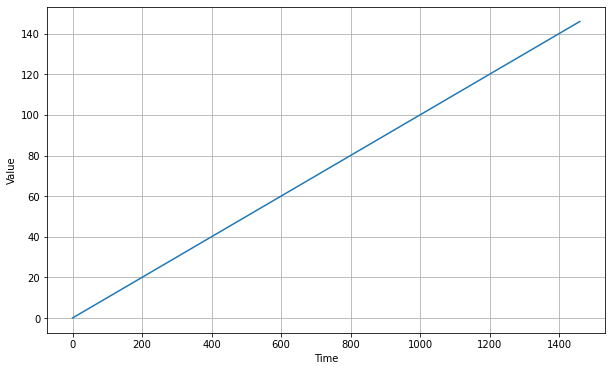

In [6]:
#Make Time series with upward trend
time = np.arange(4*365 +1)
baseline = 10
series = trend(time*0.1)

plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()

In [7]:
#Now make a time series with seasonal pattern

In [8]:
def seasonanl_pattern(season_time):
  return np.where(season_time<0.4, np.cos(season_time*2*np.pi), 1/np.exp(3*season_time))

def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time+phase) % period)/period
  return amplitude*seasonanl_pattern(season_time)

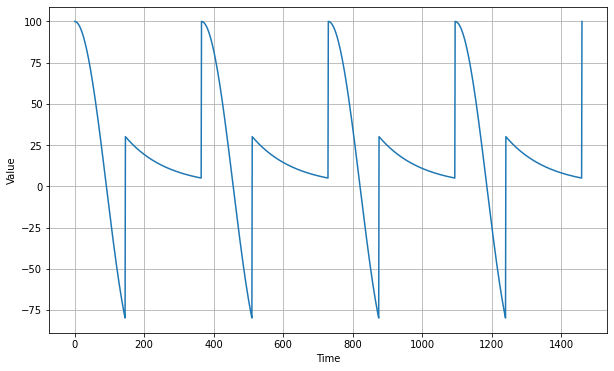

In [9]:
baseline = 10
amplitude = 100
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()

In [10]:
# Time series with both trend and seasonality combine

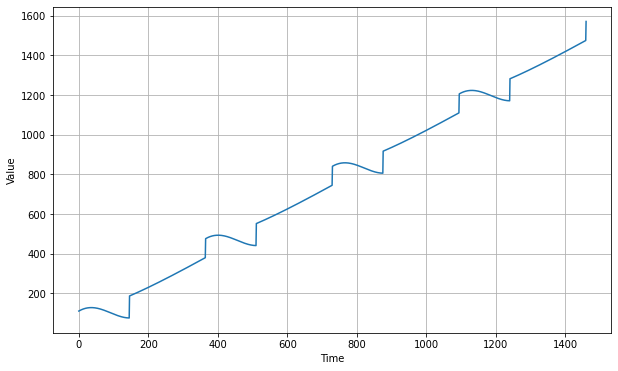

In [11]:
slope = 0.5
series = baseline +trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

In [12]:
#Now add some noise

In [13]:
def white_noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time))*noise_level

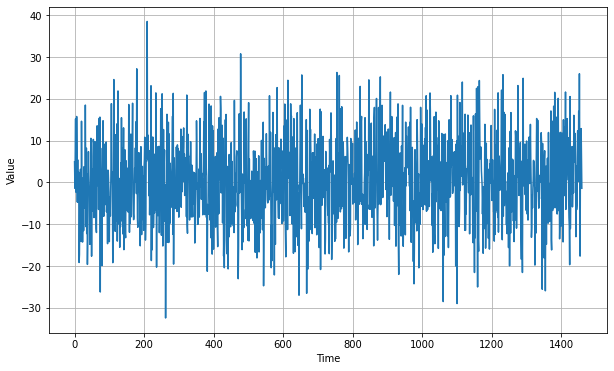

In [14]:
noise_level = 10
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10,6))
plot_series(time,noise)
plt.show()

In [15]:
#  Add the noiseto time series  

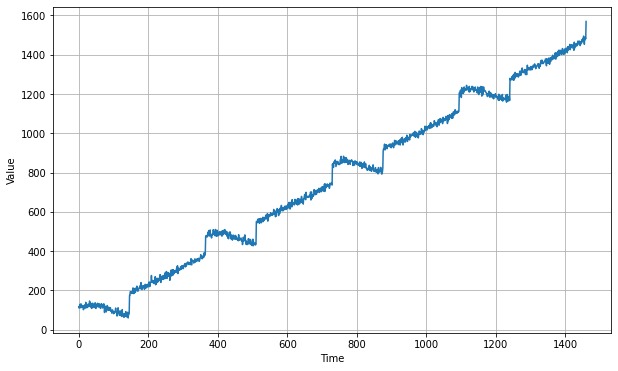

In [16]:
series += noise
plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()

In [17]:
# Now, we will try to forecast it with some ML-magic thing

In [18]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time]

In [19]:
#Define the function autocorrelation

# def autocorrelation(time, amplitide, seed=None):
#   rnd = np.random.RandomState(seed)
#   psi1 = 0.5
#   psi2 = -0.1
#   ar = rnd.randn(len(time) + 50)
#   ar[:50] = 100
#   for step in range(50, len(time) + 50):
#     ar[step] += psi1 * ar[step-50]
#     ar[step] += psi2 * ar[step-33] 
#   return ar[50:] * amplitude  

In [20]:
# Another function that will show different graph
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ = 0.8
    ar = rnd.randn(len(time) + 1)
    for step in range(1, len(time) + 1):
        ar[step] += φ * ar[step - 1]
    return ar[1:] * amplitude

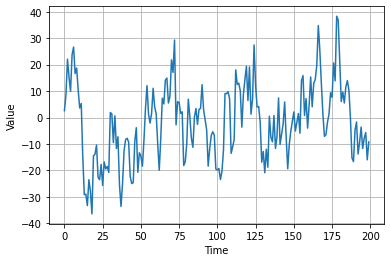

In [21]:
# Autocorrelation in action
series = autocorrelation(time, 10, seed=42)
plot_series(time[:200], series[:200])
plt.show()

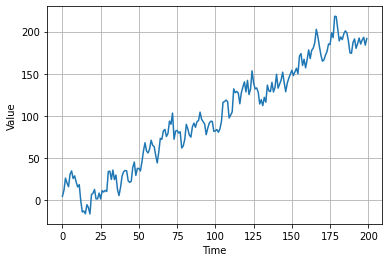

In [22]:
# Autocorrelation + trend in action
series = autocorrelation(time, 10, seed=42) + trend(time,2)
plot_series(time[:200], series[:200])
plt.show()

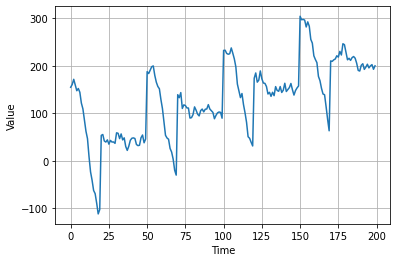

In [23]:
# Autocorrelation + trend + seasonality in action
series = autocorrelation(time,10,seed=42) + seasonality(time, period=50, amplitude=150) + trend(time,2)
plot_series(time[:200], series[:200])
plt.show()

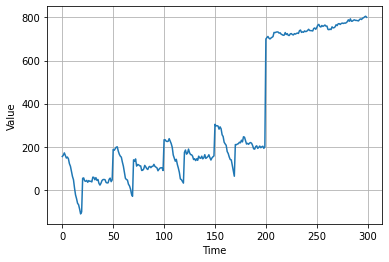

In [25]:
# Combine 2 series
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time,2)
series2 = autocorrelation(time, 5 ,seed=42) + seasonality(time, period=50, amplitude=2) + trend(time,-1) +500
series[200:] = series2[200:]

plot_series(time[:300], series[:300])
plt.show()

In [26]:
# Set Impulse
def impulses(time, num_impulses, amplitude=1, seed=None):
  rnd = np.random.RandomState(seed)
  impulse_indices = rnd.randint(len(time), size=10)
  series = np.zeros(len(time))
  for index in impulse_indices:
    series[index] += rnd.rand() * amplitude
  return series  

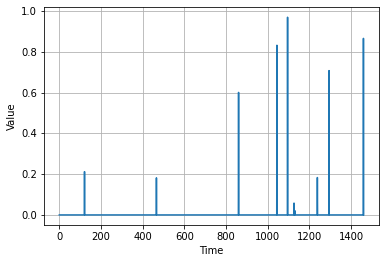

In [27]:
series = impulses(time, 10, seed=42)
plot_series(time, series)
plt.show()

In [28]:
# Autocorrelation in impulse
def autocorrelation(source, psis):
  ar = source.copy()
  max_lag = len(psis)
  for step, value in enumerate(source):
    for lag, psi in psis.items():
      if step - lag > 0:
        ar[step] += psi * ar[step-lag]
  return ar      

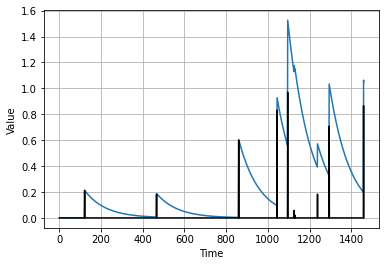

In [29]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1:0.99})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

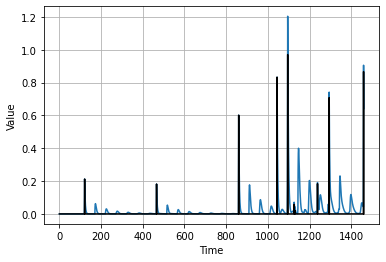

In [30]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1:0.7, 50:0.2})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

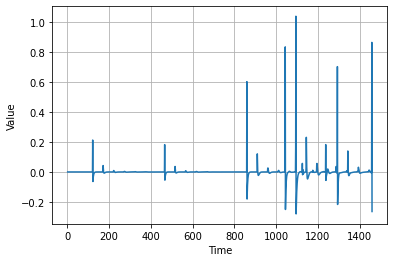

In [31]:
series_diff1 = series[1:] - series[:-1]
plot_series(time[1:], series_diff1)

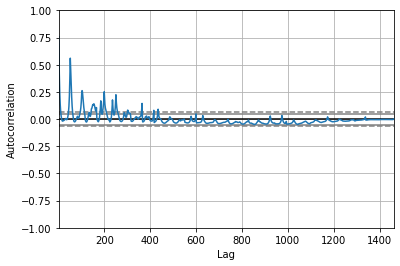

In [32]:
#Plot aurocorrelation  using pandas
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)

In [34]:
# Summary using Arima 
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(5,1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1460
Model:                 ARIMA(5, 1, 0)   Log Likelihood                2223.428
Method:                       css-mle   S.D. of innovations              0.053
Date:                Wed, 26 May 2021   AIC                          -4432.855
Time:                        17:19:41   BIC                          -4395.852
Sample:                             1   HQIC                         -4419.052
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.384      0.701      -0.001       0.002
ar.L1.D.y     -0.1235      0.026     -4.715      0.000      -0.175      -0.072
ar.L2.D.y     -0.1254      0.029     -4.333      0.0